In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
cell_centroids = np.loadtxt("case/mesh/cell/centroid")

In [13]:
i = 2600

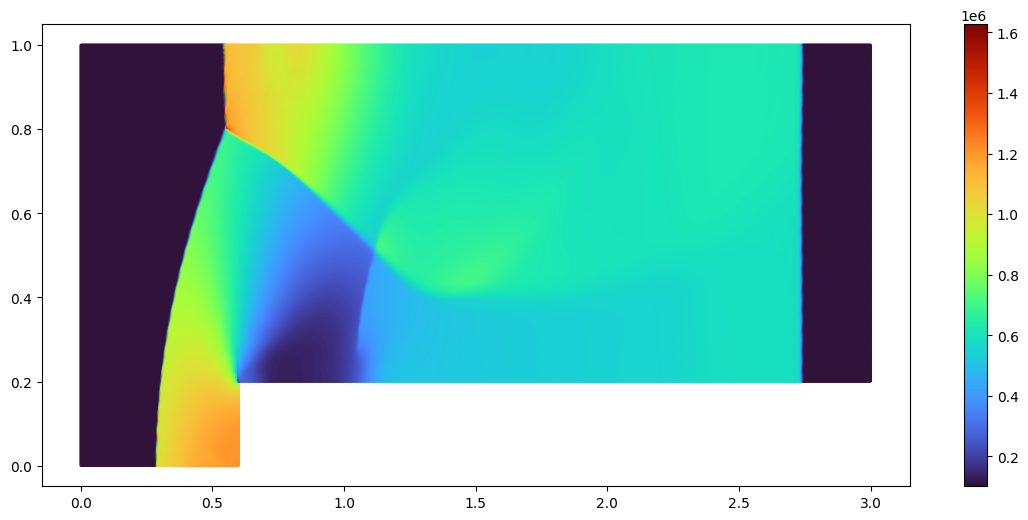

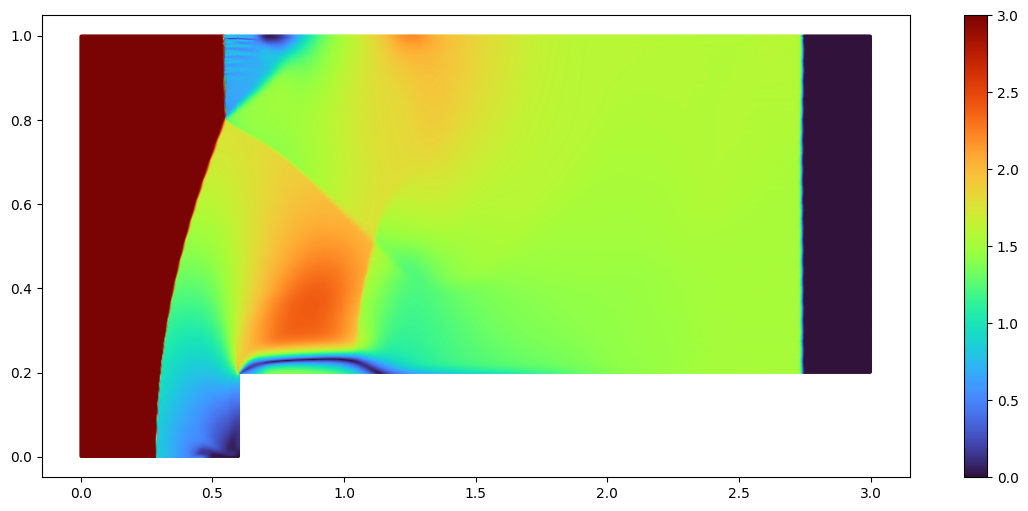

In [14]:
p = np.fromfile(f"case/solution/{i}/p")
v = np.fromfile(f"case/solution/{i}/v").reshape((-1,3))
T = np.fromfile(f"case/solution/{i}/T")

plt.figure(figsize=(14,6))
plt.scatter(
    cell_centroids[:, 0],
    cell_centroids[:, 1],
    c=p,
    s=2,
    cmap="turbo"
)
plt.colorbar()
plt.show()

plt.figure(figsize=(14,6))
plt.scatter(
    cell_centroids[:, 0],
    cell_centroids[:, 1],
    c=np.sqrt(v[:,0]**2+v[:,1]**2+v[:,2]**2)/347,
    s=2,
    cmap="turbo"
)
plt.colorbar()
plt.show()

In [1]:
import evtk as evtk
import numpy as np
import matplotlib.pyplot as plt
import meshio as mio
import os as os

from tqdm import tqdm

In [2]:
mesh_info = np.loadtxt("case/mesh/info", dtype=np.int64)

n_faces = mesh_info[1]
n_cells = mesh_info[2]

cells_centroid = np.loadtxt("case/mesh/cell/centroid", dtype=np.float64)

cells_n_faces = np.loadtxt("case/mesh/cell/n_faces")[0:n_cells]

cells_types = np.zeros(n_cells)
cells_types[cells_n_faces==6] = evtk.vtk.VtkHexahedron.tid

cells_n_faces = np.loadtxt("case/mesh/cell/n_faces", dtype=np.int64)
cells_i_start_face = np.loadtxt("case/mesh/cell/i_start_face", dtype=np.int64)

cells_i_faces = np.loadtxt("case/mesh/cell/i_faces", dtype=np.int64)

faces_centroid = np.loadtxt("case/mesh/face/centroid", dtype=np.float64)
faces_normal = np.loadtxt("case/mesh/face/normal", dtype=np.float64)

faces_n_nodes = np.loadtxt("case/mesh/face/n_nodes", dtype=np.int64)
faces_i_start_node = np.loadtxt("case/mesh/face/i_start_node", dtype=np.int64)

faces_i_nodes = np.loadtxt("case/mesh/face/i_nodes", dtype=np.int64)
cells_face_connectivity = []

for i in range(n_cells):
    i_f_0 = cells_i_start_face[i]
    n_f = cells_n_faces[i]
    cells_face_connectivity.append(cells_i_faces[i_f_0:i_f_0+n_f])    
    
faces_node_connectivity = []

for i in range(n_faces):
    i_n_0 = faces_i_start_node[i]
    n_n = faces_n_nodes[i]
    faces_node_connectivity.append(faces_i_nodes[i_n_0:i_n_0+n_n])    
    
cells_face_connectivity = np.array(cells_face_connectivity, dtype=np.int64)
faces_node_connectivity = np.array(faces_node_connectivity, dtype=np.int64)

nodes_centroid = np.loadtxt("case/mesh/node/centroid")

In [3]:
vtk_hexahedron_order = [0, 1, 2, 3, 4, 5, 6, 7]
faces_node_connectivity = []

for i in range(n_faces):
    i_n_0 = faces_i_start_node[i]
    n_n = faces_n_nodes[i]
    faces_node_connectivity.append(faces_i_nodes[i_n_0:i_n_0+n_n])    

faces_node_connectivity = np.array(faces_node_connectivity, dtype=np.int64)
cells_face_connectivity = []

for i in range(n_cells):
    i_f_0 = cells_i_start_face[i]
    n_f = cells_n_faces[i]
    cells_face_connectivity.append(cells_i_faces[i_f_0:i_f_0+n_f])    

cells_face_connectivity = np.array(cells_face_connectivity, dtype=np.int64)
cells_node_connectivity = []

for i in range(n_cells):
    face_indices = cells_face_connectivity[i]
    node_set = set()

    for face_index in face_indices:
        nodes = faces_node_connectivity[face_index]
        node_set.update(nodes)

    nodes = list(node_set)

    if len(nodes) == 8:
        cell_centroid = cells_centroid[i]
        nodes.sort(key=lambda node: np.linalg.norm(nodes_centroid[node] - cell_centroid))

        sorted_by_z = sorted(nodes, key=lambda node: nodes_centroid[node][2])
        
        bottom_nodes = sorted_by_z[:4]
        top_nodes = sorted_by_z[4:]
        
        bottom_nodes.sort(key=lambda node: np.arctan2(
            nodes_centroid[node][1] - cell_centroid[1],
            nodes_centroid[node][0] - cell_centroid[0]
        ))
        
        top_nodes.sort(key=lambda node: np.arctan2(
            nodes_centroid[node][1] - cell_centroid[1],
            nodes_centroid[node][0] - cell_centroid[0]
        ))
        
        ordered_nodes = bottom_nodes + top_nodes
        cells_node_connectivity.append([ordered_nodes[i] for i in vtk_hexahedron_order])
    else:
        cells_node_connectivity.append(list(node_set))

cells_node_connectivity = np.array(cells_node_connectivity, dtype=np.int64)

In [ ]:
with mio.xdmf.TimeSeriesWriter("paraview_case.xdmf", data_format="HDF") as writer:
    writer.write_points_cells(nodes_centroid, [("hexahedron", cells_node_connectivity)])
    for t in tqdm(range(10, 5000 + 1, 10)):
        writer.write_data(
            t,
            cell_data={
                # "p": np.loadtxt(f"case/solution/{t}/p").reshape(-1, 1),
                # "v": np.loadtxt(f"case/solution/{t}/v"),
                # "T": np.loadtxt(f"case/solution/{t}/T").reshape(-1, 1),
                "p": np.fromfile(f"case/solution/{t}/p").reshape(-1, 1),
                "v": np.fromfile(f"case/solution/{t}/v").reshape((-1,3)),
                "T": np.fromfile(f"case/solution/{t}/T").reshape(-1, 1),
            },
        )